# Análise de dados: Anúncios em redes sociais

Este é um projeto de machine learning para análise de dados de usuários que efetuaram ou não uma compra, os dados foram disponibilizados na plataforma [Kaggle](https://www.kaggle.com/datasets/dragonheir/logistic-regression).

Não estão definidos no dataset o caso proposto e o problema a ser solucionado, então baseados nos dados serem de compras efetuadas ou não por usuários e arquivo de dados ser nomeado como "anúncios de redes sociais", será adotada a seguinte interpretação: *O arquivo Social_Network_Ads.csv contém dados de usuários de uma rede social que tiveram alguma interação com um anúncio e foram incentivados ou não a efetuar uma compra, sendo assim o objetivo do desenvolvimento do modelo será em prever quais clientes estimulados pelo(s) anúncio(s) realizará ou não uma compra.*

## Demanda da análise

- Analisar a correlação dos dados dos usuários.
- Gerar um modelo preditivo de compra ou não por um usuário.
- Simular novas entradas de dados e previsões.

## Tópicos da análise

1. Análise das medidas estatísticas dos dados
2. Distribuição dos dados entre as variáveis independentes (features) e dependente (target)
3. Correlação entre as variáveis
4. Criação do modelo de regressão logística
   1. Separação dos dados de treino e teste
   2. Treinamento e predições do modelo
   3. Métricas do modelo
   4. Previsões com novos dados
5. Conclusão


## Importação de pacotes


In [199]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             roc_curve,
                             roc_auc_score)
from imblearn.over_sampling import SMOTE
from tabulate import tabulate


warnings.filterwarnings('ignore')
sns.set_style('darkgrid')


## Carregamento dos dados


In [200]:
# Efetuando limpeza de memória antes do carregamento de dados
gc.collect()

# Caminho do arquivo
path = 'dados/Social_Network_Ads.csv'

# Criando um dataframe a partir do arquivo no diretório dados
df = pd.read_csv(path, encoding='utf-8', sep=',')


## Detalhes do dataframe


In [201]:
# Informações do dataset como nome das colunas, contagem de linhas,
# tipo de dados e memória utilizada

df.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 36.9 KB


In [202]:
# Amostra de dados do dataframe

df.sample(10)


,User ID,Gender,Age,EstimatedSalary,Purchased
18,15704583,Male,46,28000,1
294,15566689,Female,35,57000,0
296,15673539,Male,42,73000,1
99,15756820,Female,28,37000,0
118,15642725,Male,40,59000,0
268,15746203,Female,47,144000,1
71,15726358,Female,24,27000,0
275,15727467,Male,57,74000,1
66,15679760,Male,24,19000,0
70,15756932,Male,25,80000,0


In [203]:
# Renomeando as colunas

print("\nNomes originais das colunas\n\n", df.columns.to_list())

df.rename(columns={'User ID': 'id_usuario',
                   'Gender': 'genero',
                   'Age': 'idade',
                   'EstimatedSalary': 'salario_estimado',
                   'Purchased': 'comprado'},
          inplace=True)

print("\nNovos nomes das colunas\n\n", df.columns.to_list())



Nomes originais das colunas

 ['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased']

Novos nomes das colunas

 ['id_usuario', 'genero', 'idade', 'salario_estimado', 'comprado']


In [204]:
# Quantidade de linhas e colunas

df.shape


(400, 5)

## Removendo colunas que não serão utilizadas


In [205]:
df = df.drop(columns=['id_usuario'])


## Verificando e tratando se necessário os valores duplicados


In [206]:
# Identificando a quantidade de valores duplicados (True)

df.duplicated(keep='first').value_counts()


False    380
True      20
dtype: int64

In [207]:
# Listando os valores duplicados e definindo a ação a ser tomada

display(df[df.duplicated()])


print('''Embora exista uma quantidade considerável de dados duplicados se 
comparado a toda a amostra de dados, cada registro é identificado pela 
coluna 'id_usuario' ('User ID') que é exclusivo/único de cada usuário, as 
colunas 'genero', 'idade', 'salario_estimado' e 'comprado', sendo que a 
coluna 'salario_estimado', como o próprio nome diz, é uma estimativa de 
ganho do usuário, logo estes dados apontados como duplicados serão mantidos 
no dataframe.''')


,genero,idade,salario_estimado,comprado
74,Male,32,18000,0
94,Female,29,83000,0
186,Female,20,82000,0
192,Male,29,43000,0
231,Male,39,42000,0
236,Male,40,57000,0
256,Female,41,72000,0
257,Male,40,57000,0
312,Female,38,50000,0
322,Male,41,52000,0


Embora exista uma quantidade considerável de dados duplicados se 
comparado a toda a amostra de dados, cada registro é identificado pela 
coluna 'id_usuario' ('User ID') que é exclusivo/único de cada usuário, as 
colunas 'genero', 'idade', 'salario_estimado' e 'comprado', sendo que a 
coluna 'salario_estimado', como o próprio nome diz, é uma estimativa de 
ganho do usuário, logo estes dados apontados como duplicados serão mantidos 
no dataframe.


## Verificando e tratando se necessário os valores únicos


In [208]:
# Verificando a quantidade de valores únicos

df.nunique()


genero                2
idade                43
salario_estimado    117
comprado              2
dtype: int64

In [209]:
# Verificando a quantidade dos valores únicos de colunas específicas

genero_qtde = pd.DataFrame(df['genero'].value_counts().sort_index())
genero_qtde = genero_qtde.T
print(genero_qtde)

idade_qtde = pd.DataFrame(df['idade'].value_counts().sort_index())
idade_qtde = idade_qtde.T
print('\n', idade_qtde)

comprado_qtde = pd.DataFrame(df['comprado'].value_counts().sort_index())
comprado_qtde = comprado_qtde.T
print('\n', comprado_qtde)


        Female  Male
genero     204   196

        18  19  20  21  22  23  24  25  26  27  ...  51  52  53  54  55  56  \
idade   5   7   7   4   5   6   9   6  16  13  ...   3   6   5   4   3   3   

       57  58  59  60  
idade   5   6   7   7  

[1 rows x 43 columns]

             0    1
comprado  257  143


In [210]:
# Transformando os valores da categoria 'genero' em categorias distintas e
# traduzindo os valores da categoria 'genero'

arr_genero = OneHotEncoder().fit_transform(
    df['genero'].values.reshape(-1, 1)).toarray()
df_genero = pd.DataFrame(arr_genero)
df_genero.rename(columns={0: 'feminino', 1: 'masculino'}, inplace=True)
df = pd.concat([df, df_genero], axis=1)
df['genero'].replace({'Male': 'Masculino', 'Female': 'Feminino'}, inplace=True)
df.head(10)


,genero,idade,salario_estimado,comprado,feminino,masculino
0,Masculino,19,19000,0,0.0,1.0
1,Masculino,35,20000,0,0.0,1.0
2,Feminino,26,43000,0,1.0,0.0
3,Feminino,27,57000,0,1.0,0.0
4,Masculino,19,76000,0,0.0,1.0
5,Masculino,27,58000,0,0.0,1.0
6,Feminino,27,84000,0,1.0,0.0
7,Feminino,32,150000,1,1.0,0.0
8,Masculino,25,33000,0,0.0,1.0
9,Feminino,35,65000,0,1.0,0.0


## Verificando e tratando se necessário os tipos de valores


In [211]:
# Identificando os tipos de dados das colunas

df.dtypes


genero               object
idade                 int64
salario_estimado      int64
comprado              int64
feminino            float64
masculino           float64
dtype: object

## Verificando e tratando se necessário os valores nulos


In [212]:
# Identificando a quantidade de valores nulos

df.isnull().sum()


genero              0
idade               0
salario_estimado    0
comprado            0
feminino            0
masculino           0
dtype: int64

## Amostra de dados do dataframe


In [213]:
df.sample(10)


,genero,idade,salario_estimado,comprado,feminino,masculino
308,Masculino,36,125000,1,0.0,1.0
182,Feminino,32,117000,1,1.0,0.0
218,Feminino,46,96000,0,1.0,0.0
280,Feminino,59,88000,1,1.0,0.0
328,Masculino,36,118000,1,0.0,1.0
187,Feminino,33,41000,0,1.0,0.0
349,Masculino,38,61000,0,0.0,1.0
269,Masculino,40,61000,0,0.0,1.0
30,Masculino,31,74000,0,0.0,1.0
346,Masculino,53,72000,1,0.0,1.0


## 1. Análise das medidas estatísticas dos dados


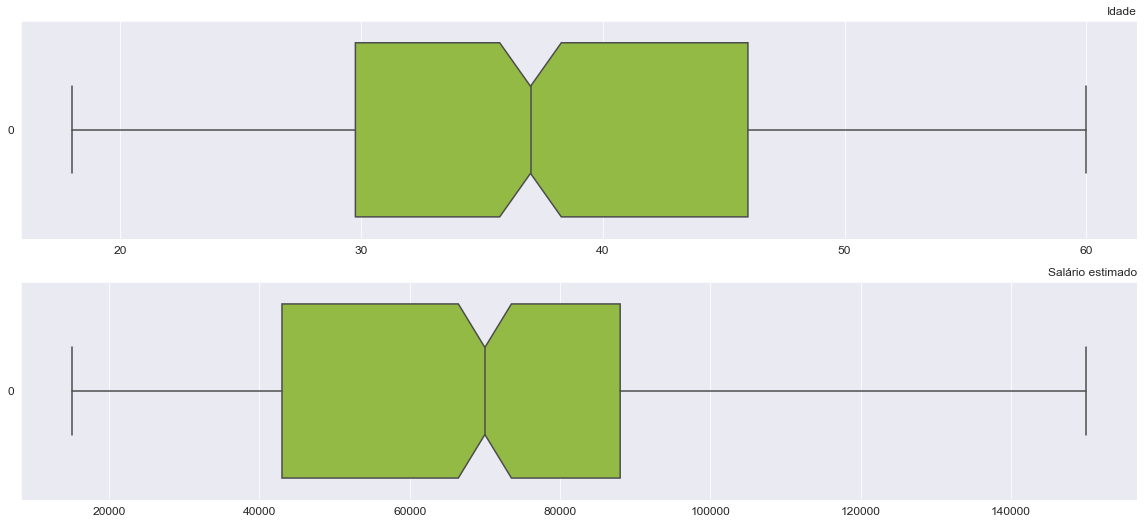

In [214]:
# Função para gerar gráficos boxplot
# param1: coluna do dataframe
# param2: label para gráfico
# param3: axis
# param4: cor, defaut: 'yellowgreen'

def graf_boxplot(param1, param2, param3, param4='yellowgreen'):
    sns.boxplot(data=param1, ax=param3, color=param4, notch=True, orient='h')
    param3.set(xlabel='', ylabel='')
    param3.tick_params(labelsize=12)
    param3.ticklabel_format(style='plain', axis='x')
    param3.set_title(param2, loc='right', fontsize=12)


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 7))

graf_boxplot(df['idade'], 'Idade', ax1)
graf_boxplot(df['salario_estimado'], 'Salário estimado', ax2)

plt.subplots_adjust(top=1.9, bottom=0.95)
plt.show()


In [215]:
# Descrição dos dados estatísticos

df[['idade', 'salario_estimado']].describe().T


,count,mean,std,min,25%,50%,75%,max
idade,400.0,37.655,10.482877,18.0,29.75,37.0,46.0,60.0
salario_estimado,400.0,69742.500,34096.960282,15000.0,43000.00,70000.0,88000.0,150000.0


## 2. Distribuição dos dados entre as variáveis independentes (features) e dependente (target)


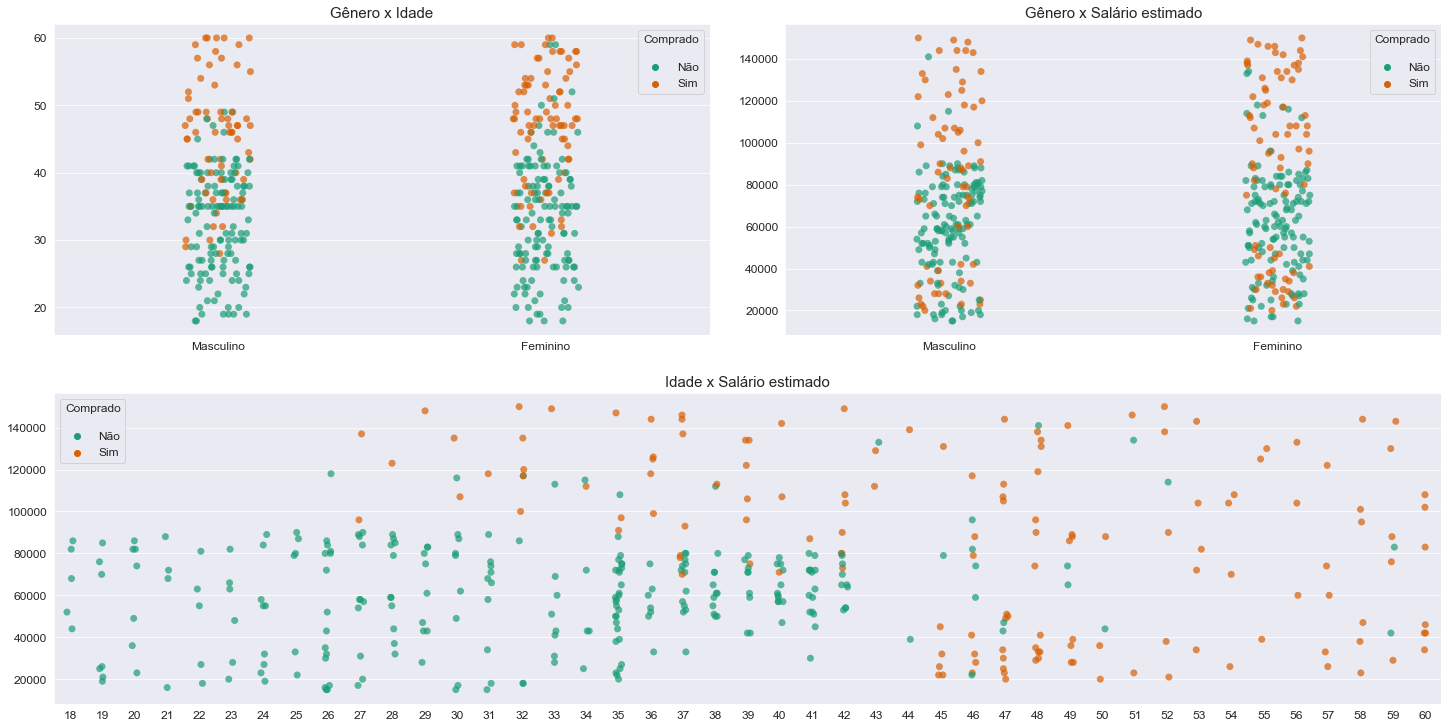

In [216]:
# Função para gerar gráficos stripplot
# param1: nome do dataframe
# param2: variável do eixo X
# param3: variável do eixo Y
# param4: axis
# param5: spec
# param6: label para gráfico
# param7: paleta de cores, default: Dark2

comprado = df['comprado'].replace({1: 'Sim', 0: 'Não'})


def graf_2_stripplot(param1, param2, param3, param4, param5, param6, param7='Dark2'):
    param4 = fig.add_subplot(param5)
    sns.stripplot(data=param1, x=param2, y=param3,
                  ax=param4, hue=comprado, palette=param7, s=7, alpha=0.7)
    param4.set(xlabel='', ylabel='')
    param4.legend(title='Comprado\n', fontsize=12, title_fontsize=12)
    param4.tick_params(labelsize=12)
    param4.ticklabel_format(style='plain', axis='y')
    param4.set_title(param6, fontsize=15)


fig = plt.figure(figsize=(20, 10), constrained_layout=True)
spec = fig.add_gridspec(2, 2)

ax1 = ax2 = ax3 = None

graf_2_stripplot(df, 'genero', 'idade', ax1, spec[0, 0],
                 'Gênero x Idade')
graf_2_stripplot(df, 'genero', 'salario_estimado', ax2, spec[0, 1],
                 'Gênero x Salário estimado')
graf_2_stripplot(df, 'idade', 'salario_estimado', ax3, spec[1, 0:],
                 '\nIdade x Salário estimado')
plt.show()


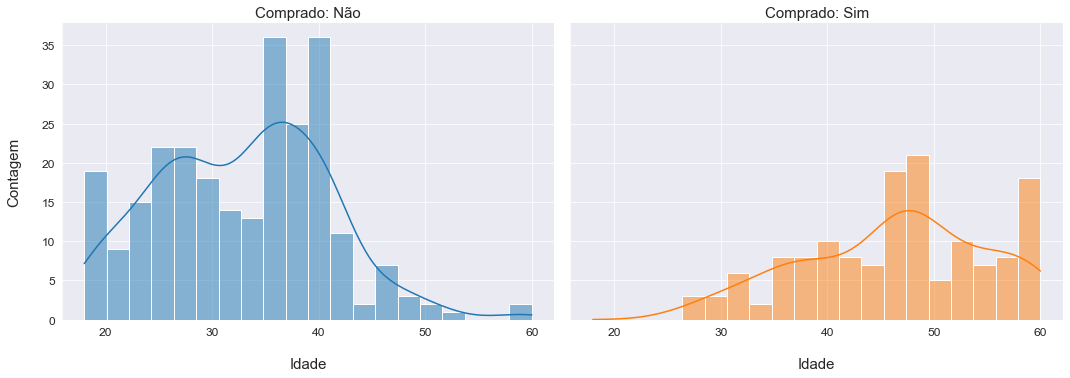

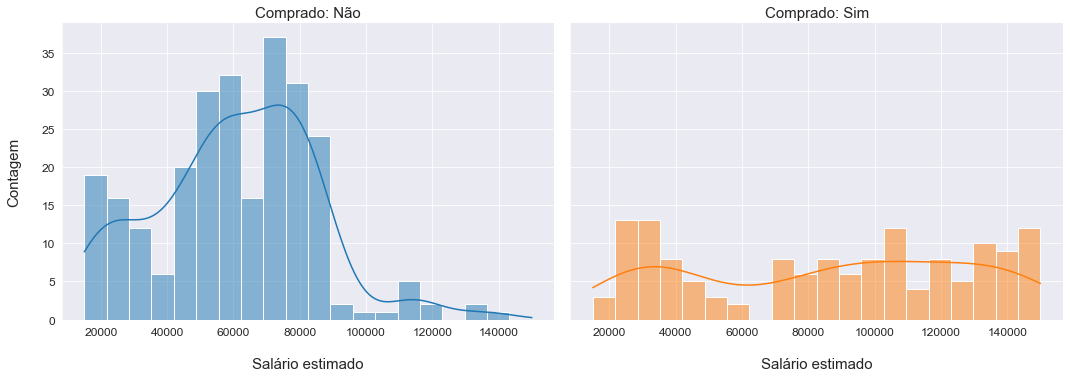

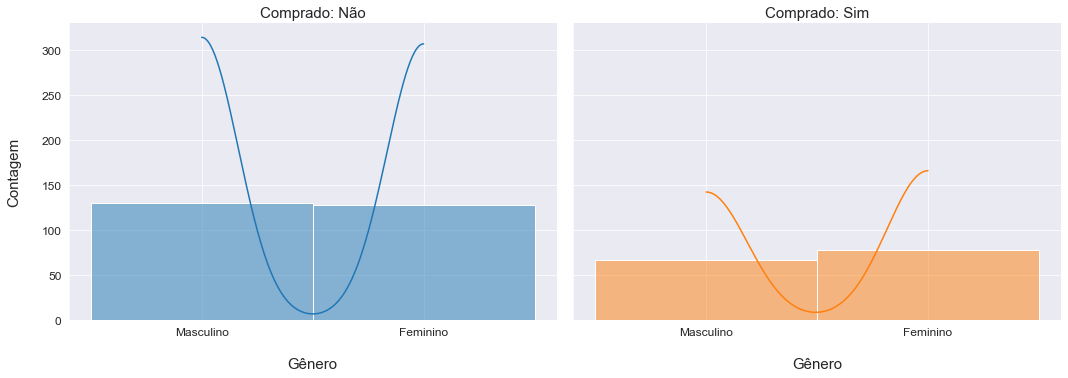

In [217]:
# Função para gerar gráficos displot
# param1: nome do dataframe
# param2: variável do eixo X
# param3: label para gráfico
# param4: cor, default: royalblue

def graf_displot(param1, param2, param3, param4='royalblue'):
    plot = sns.displot(data=param1, x=param2, col=comprado,
                       color=param4, kde=True, bins=20, hue=comprado, legend=False)
    plot.tick_params(labelsize=12)
    plot.set_axis_labels(param3, 'Contagem\n', size=15)
    plot.set_titles('Comprado: {col_name}', size=15)
    plot.figure.set_size_inches(15, 5)


graf_displot(df, 'idade', '\nIdade')
graf_displot(df, 'salario_estimado', '\nSalário estimado')
graf_displot(df, 'genero', '\nGênero')

plt.show()


## 3. Correlação entre as variáveis


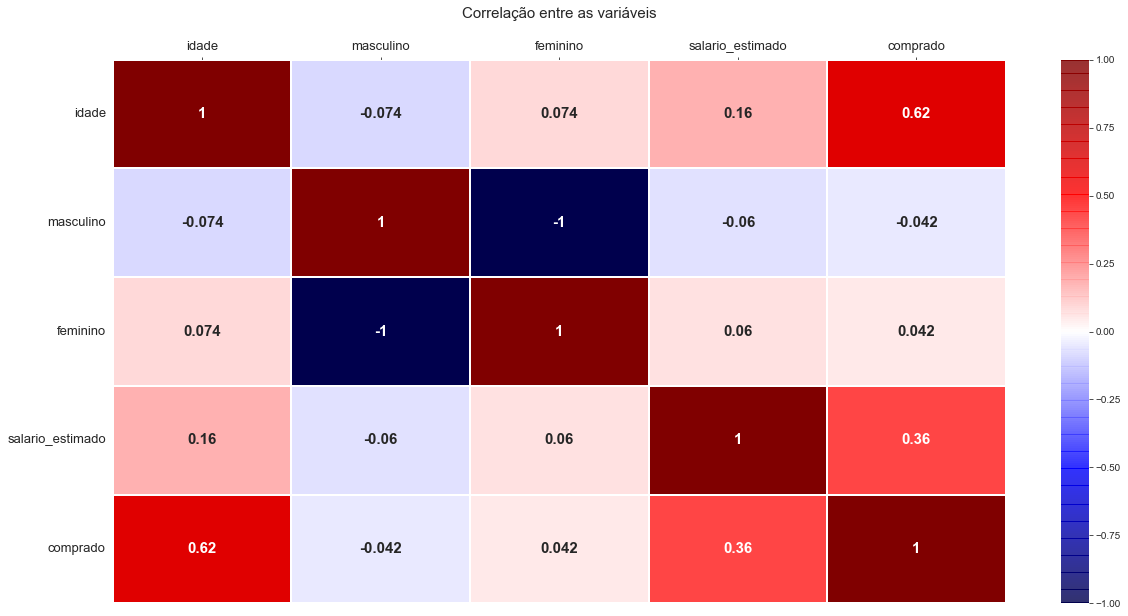

In [218]:

corr = df[['idade', 'masculino', 'feminino',
           'salario_estimado', 'comprado', ]].corr()


plt.figure(figsize=(20, 10))
plot = sns.heatmap(data=corr,
                   annot=True, annot_kws={'size': 15, 'fontweight': 'bold'},
                   cbar_kws={'extendfrac': .1, 'drawedges': True},
                   cmap='seismic', vmin=-1, linewidths=.2,
                   xticklabels=['idade', 'masculino', 'feminino',
                                'salario_estimado', 'comprado'],
                   yticklabels=['idade', 'masculino', 'feminino',
                                'salario_estimado', 'comprado']
                   )
plot.set_yticklabels(plot.get_yticklabels(), rotation=0)
plot.set_title('Correlação entre as variáveis\n', loc='center', fontsize=15)
plot.tick_params(labelsize=13)
plot.xaxis.tick_top()
plt.show()


## 4. Criação do modelo de regressão logística


### 1. Separação dos dados de treino e teste


In [219]:

# features, variáveis independentes
X = df.drop(['comprado', 'genero'], axis=1)

# padronizando os dados das features
std = StandardScaler().fit(X)
X = std.transform(X)

# target, variável dependente
y = df['comprado'].copy()

# definindo o percentual de dados para teste
perc = 0.25

# definindo o random_state
seed = 10

# separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=perc, random_state=seed)

print('\nQuantidade de dados divididos em treino e teste')
print('\nX_train:', X_train.shape)
print('y_train:', y_train.shape)
print('\nX_test:', X_test.shape)
print('y_test:', y_test.shape)



Quantidade de dados divididos em treino e teste

X_train: (300, 4)
y_train: (300,)

X_test: (100, 4)
y_test: (100,)


In [220]:
# aplicando balanceamento

print("\nDesbalanceado")
print(y_train.value_counts())

sample = SMOTE(sampling_strategy='minority', random_state=42)

X_train_b, y_train_b = sample.fit_resample(X_train, y_train)

print("\nBalanceado")
print(y_train_b.value_counts())



Desbalanceado
0    188
1    112
Name: comprado, dtype: int64

Balanceado
0    188
1    188
Name: comprado, dtype: int64


In [221]:
# definição do modelo a ser utilizado nos dados
# o algoritmo 'liblinear' é utilizado para pequenos conjuntos de dados
modelo_rl = LogisticRegression(solver='liblinear')
print('\nModelo selecionado:', modelo_rl)



Modelo selecionado: LogisticRegression(solver='liblinear')


### 2. Treinamento e predições do modelo


In [222]:
# treinamento do modelo
modelo_rl.fit(X_train_b, y_train_b)

# predição com dados de teste
pred_test = modelo_rl.predict(X_test)

pred_test


array([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0], dtype=int64)

### 3. Métricas do modelo


In [223]:
# Acurácia do modelo
acuracia = accuracy_score(y_test, pred_test) * 100
print('\nO modelo obteve %0.2f de acurácia.' % acuracia)



O modelo obteve 90.00 de acurácia.


In [224]:
# Matriz de confusão, irá demonstrar visualmente as quantidades de
# previsões verdadeiras e que o modelo também identificou dessa forma
# os verdadeiros positivos (1 - sim) e os verdadeiros negativos (0 - não)

matrix = confusion_matrix(y_test, pred_test)

arr = matrix.T

data = {
    '': ['0', '1'],
    '0': [i for i in arr[0]],
    '1': [i for i in arr[1]],
}

print('\nMatriz de confusão')

print(tabulate(data, headers='keys', tablefmt='grid'))



Matriz de confusão
+----+-----+-----+
|    |   0 |   1 |
+====+=====+=====+
|  0 |  61 |   8 |
+----+-----+-----+
|  1 |   2 |  29 |
+----+-----+-----+


In [225]:
# - Precision: percentual de acerto ao classificar uma predição em verdadeira positiva (1 - sim)
#   em relação as predições verdadeiras e falsas positivas.
# - Recall: percentual de acerto ao classificar uma predição em verdadeira positiva (1 - sim)
#   em relação as predições verdadeiras positivas e falsas negativas.
# - F1-score: média ponderada entre 'precision' e 'recall'.
# - Support: número de classificações das predições.

print('\n', classification_report(y_test, pred_test))



               precision    recall  f1-score   support

           0       0.97      0.88      0.92        69
           1       0.78      0.94      0.85        31

    accuracy                           0.90       100
   macro avg       0.88      0.91      0.89       100
weighted avg       0.91      0.90      0.90       100



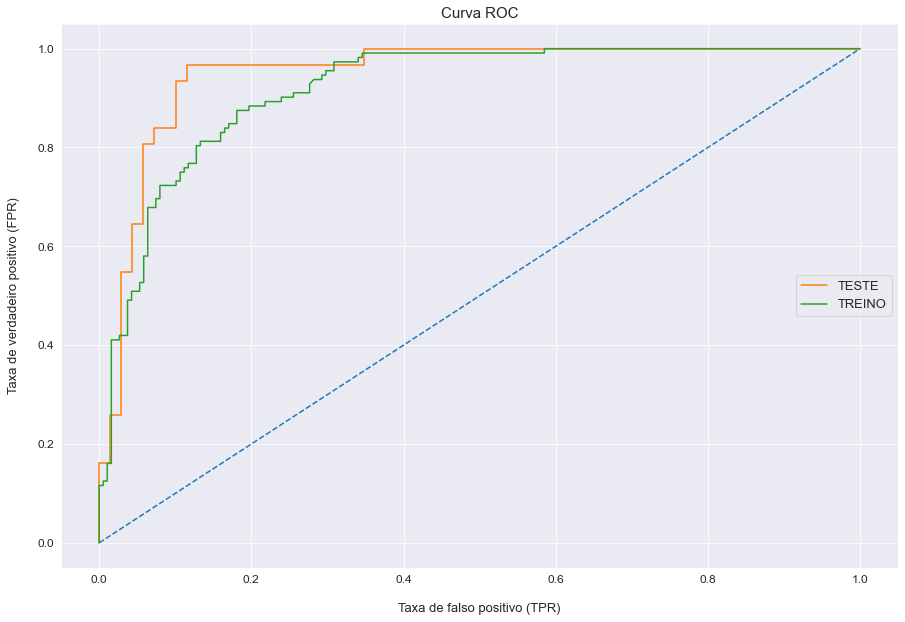

In [226]:
# Calculando as probabilidades com dados de treino e teste
pred_test_prob = modelo_rl.predict_proba(X_test)[:, 1]
pred_train_prob = modelo_rl.predict_proba(X_train)[:, 1]

# Gera fpr (Taxa de falso positivo), tpr (Taxa de falso positivo) e thresholds
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred_test_prob)
fpr2, tpr2, thresholds2 = roc_curve(y_train, pred_train_prob)

# Gráfico da curva ROC
plt.figure(figsize=(15, 10))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr1, tpr1, label='TESTE')
plt.plot(fpr2, tpr2, label='TREINO')
plt.tick_params(labelsize=12)
plt.xlabel('\nTaxa de falso positivo (TPR)', fontsize=13)
plt.ylabel('Taxa de verdadeiro positivo (FPR)\n', fontsize=13)
plt.title('Curva ROC', fontsize=15)
plt.legend(loc='center right', fontsize=13)
plt.show()


In [227]:
# Calculando o AUC (Área sob a curva ROC)
auc_score_test = roc_auc_score(y_test, pred_test_prob)
auc_score_train = roc_auc_score(y_train, pred_train_prob)

print('\nAUC dados de teste: ', auc_score_test)
print('\nAUC dados de treino:', auc_score_train)



AUC dados de teste:  0.9495091164095372

AUC dados de treino: 0.9191441869300913


In [228]:
# definindo os valores dos hiperparâmetros

# definindo o número de folds, número de divisões dos dados
numero_folds = 10

# definindo o random_state
seed = 5

# separando os dados em folds
kfold = KFold(n_splits=numero_folds, shuffle=True, random_state=seed)

# array de score de cada fold
resultado = cross_val_score(modelo_rl, X, y, cv=kfold)

print('\nMétrica do modelo utilizando Cross Validation')
print('\nScore de cada fold:', resultado * 100)
print('\nScore (média):', resultado.mean() * 100)



Métrica do modelo utilizando Cross Validation

Score de cada fold: [85.  87.5 87.5 80.  90.  85.  82.5 77.5 82.5 87.5]

Score (média): 84.5


### 4. Previsões com novos dados


In [229]:
# Função para testar o modelo com novos dados
# param1: quantidade de entradas de novos dados

def teste_modelo(param1):

    arrx = []

    for i in range(param1):
        idade = np.random.randint(df['idade'].min(), df['idade'].max())
        masculino = np.random.randint(2)
        if masculino == 1:
            feminino = 0
        else:
            feminino = 1
        salario_estimado = np.random.randint(
            df['salario_estimado'].min(), df['salario_estimado'].max())
        arr = np.array([idade, masculino,
                        feminino, salario_estimado])
        arrx.append(arr)

    novos_X = np.array(arrx)
    std = StandardScaler().fit(novos_X)
    novos_X = std.transform(novos_X)
    novos_Y = modelo_rl.predict(novos_X)

    df_tab = pd.DataFrame(arrx)
    df_Y = pd.DataFrame(novos_Y)
    df_tab[4] = df_Y[0]

    print(tabulate(df_tab, headers=['idade', 'masculino',
                                    'feminino', 'salario_estimado', 'comprado'],
                   tablefmt='fancy_grid',
                   floatfmt=('.0f', '.0f', '.0f', '.0f', '.2f', '.0f')))


teste_modelo(10)


╒════╤═════════╤═════════════╤════════════╤════════════════════╤════════════╕
│    │   idade │   masculino │   feminino │   salario_estimado │   comprado │
╞════╪═════════╪═════════════╪════════════╪════════════════════╪════════════╡
│  0 │      19 │           0 │          1 │          130754.00 │          0 │
├────┼─────────┼─────────────┼────────────┼────────────────────┼────────────┤
│  1 │      26 │           0 │          1 │          148398.00 │          0 │
├────┼─────────┼─────────────┼────────────┼────────────────────┼────────────┤
│  2 │      19 │           1 │          0 │           42037.00 │          0 │
├────┼─────────┼─────────────┼────────────┼────────────────────┼────────────┤
│  3 │      35 │           1 │          0 │          102935.00 │          1 │
├────┼─────────┼─────────────┼────────────┼────────────────────┼────────────┤
│  4 │      41 │           1 │          0 │          102119.00 │          1 │
├────┼─────────┼─────────────┼────────────┼────────────────────┼

## 5. Conclusão

Após efetuar ajustes nos dados, a fim de encontrar o maior equilíbrio possível entre usuários que realizaram uma compra ou não, foi construído um modelo com acurácia de 90% e pontuação média de 84,5%. Foram executados testes com novas entradas de dados indicando clientes que potencialmente efetuariam uma compra estimulados por um anúncio específico, assim o modelo também irá permitir traçar perfis com maior probabilidade de efetuar uma compra e assim direcionar o anúncios para esse público específico.